## 2024 06/14 AutoML test

*Last Updated*: 2024-06-14

### Authors
* Nicole Tin


### Overview
This Jupyter notebook is intended to demonstrate
  
* A working pipeline of the Hand-ML model on 2024 MacOS
  * Image and Metadata Loading
  * Preprocessing - (Slow) Rembg implementation
  * Texture (LBP, GLCM) Feature Extraction
  * PyCaret Model Evaluation

### Continuing Thoughts
  
**Image Preprocessing**
* Full image preprocessing pipeline needs to be added 
  * Faster batch processing (remove background, crop without resizing(?))
  * Need to check outcome of rembg
  
**Feature Extraction**
* Does fill color/rembg/green bkg affect results?
* How does skin color affect texture results?
* Do we need to add more features?
  * Are there more features in literature?
    * Borrow from hand pose estimators?


### Key Results

- ...

In [1]:
# --- Imports
import os
import cv2
import pandas as pd
from dermaml import features

from pycaret import regression


# from dermaml import data
# import PIL
# from PIL import Image
# import numpy as np
# import mlflow # creates error
import matplotlib.pyplot as plt
# import skimage


In [2]:
# Dataset
dataset_name = "11khands"

# AutoML
experiment_name = "11khands-automl-sample-test_NT"
num_best_models = 5
random_seed = 42

# Paths
root = '/Users/nicole/Documents/GitHub/DermaML'
image_folder = '/data/source/Hands/'
csv_file = '/data/source/HandInfo.csv'

In [3]:
# -- Read the CSV file
df = pd.read_csv(root+ csv_file)
dorsals = df.loc[df['aspectOfHand'] == 'dorsal right']
dorsals = dorsals.drop_duplicates(subset=['id'])
dorsals = dorsals.groupby('skinColor').tail(3)

In [4]:
# -- Images

def read_local(image_fnames, image_dir):
    images = []
    for filename in image_fnames:
        img = cv2.imread(os.path.join(image_dir, filename))
        if (img is not None) & (len(img.shape) > 2):
            images.append(img)
    return images

# ds = hub.load('hub://activeloop/11k-hands')
# images = ds.images

image_fnames = dorsals.loc[:, 'imageName']
images = read_local(image_fnames, root+image_folder)

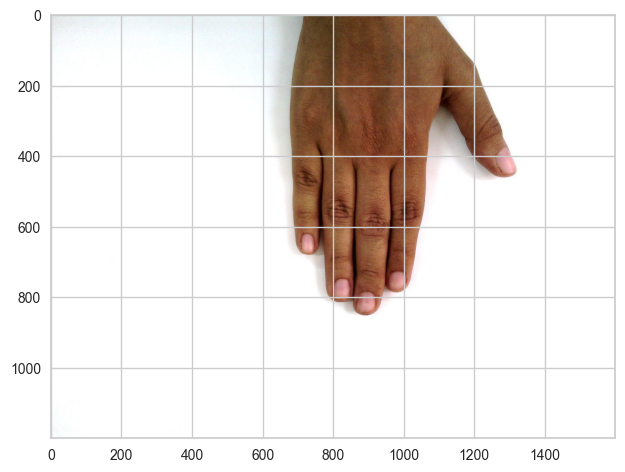

In [7]:
plt.imshow(cv2.cvtColor(images[2], cv2.COLOR_BGR2RGB))

In [5]:
# -- Image preprocessing

# for i, im in enumerate(removed_ims):
#     # Convert BGRA image to RBGA
#     grayscale_im = cv2.cvtColor(im, cv2.COLOR_BGRA2RGBA)

In [8]:
import rembg
import numpy as np

def remove_background(image: np.ndarray) -> np.ndarray:
    """
    Remove background from `image`.

    Paramerers
    ___________
    image: image data

    Return value
    ____________
    output: Numpy array containing image with background removed
    """
    # --- Check arguments

    if not isinstance(image, (np.ndarray)):
        raise TypeError(
            "`image` must be of type `np.ndarray`. "
            + f"(type(image)={type(image)}"
        )

    # --- Remove background
    #
    # Note: the return type of rembg.remove() is the same as the type of `image`
    cutout = rembg.remove(image)

    # Return numpy array representation of image with background removed
    if isinstance(cutout, np.ndarray):
        output = cutout

    else:
        print('Not sure how you got here')

    return output

iso_images = [remove_background(im) for im in images]

### Feature Extraction

In [11]:
# -- Feature Extraction
image_features = [
    features.extract_features(im)
    for im in images
    ]
X = pd.DataFrame(image_features)
X[['age', 'skinColor']] = dorsals[['age', 'skinColor']].reset_index(drop=True)

In [11]:
# Xs = []
# i = 0
# for image in images:
#     print(i, end='... ')
#     lbp_hist, _ = features.compute_lbp(image)
#     enum_lbp = dict(enumerate(lbp_hist))
#     lbp_dict = {'lbp_'+str(k):v for k,v in enum_lbp.items()}

#     contrast, correlation, energy, homogeneity = features.compute_glcm(image)
#     glcm_dict = {
#                     'contrast':contrast[0], 
#                      'correlation':correlation[0], 
#                      'energy':energy[0], 
#                      'homogeneity':homogeneity[0]
#                      }
#     feature_dict = lbp_dict | glcm_dict
#     Xs += [feature_dict]
#     i += 1

In [12]:
# --- Perform AutoML Evaluation

# Set up the dataset for AutoML regression
regression.setup(data=X,
                 target="age",
                 log_experiment=True,
                 experiment_name=experiment_name,
                 session_id=random_seed,
                ) 

best_models = regression.compare_models(n_select=num_best_models, verbose=False)


,Description,Value
0,Session id,42
1,Target,age
2,Target type,Regression
3,Original data shape,"(189, 17)"
4,Transformed data shape,"(189, 20)"
5,Transformed train set shape,"(132, 20)"
6,Transformed test set shape,"(57, 20)"
7,Numeric features,15
8,Categorical features,1
9,Preprocess,True


In [13]:
regression.pull()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,1.552900e+00,2.573370e+01,3.350700e+00,-1.169000e-01,0.1075,0.0530,0.082
dummy,Dummy Regressor,1.797600e+00,2.501280e+01,3.440100e+00,-6.188000e-01,0.1119,0.0663,0.048
br,Bayesian Ridge,1.797200e+00,2.506860e+01,3.444400e+00,-6.221000e-01,0.1121,0.0662,0.049
lasso,Lasso Regression,1.801800e+00,2.529830e+01,3.465600e+00,-6.510000e-01,0.1130,0.0663,0.037
llar,Lasso Least Angle Regression,1.801800e+00,2.529830e+01,3.465600e+00,-6.510000e-01,0.1130,0.0663,0.041
en,Elastic Net,1.800900e+00,2.531730e+01,3.466700e+00,-6.512000e-01,0.1131,0.0663,0.042
omp,Orthogonal Matching Pursuit,1.799600e+00,2.533530e+01,3.467400e+00,-6.513000e-01,0.1131,0.0662,0.046
ridge,Ridge Regression,1.951600e+00,2.782150e+01,3.910600e+00,-1.752500e+00,0.1298,0.0729,0.058
lightgbm,Light Gradient Boosting Machine,2.144800e+00,2.614860e+01,3.898600e+00,-2.175700e+00,0.1310,0.0828,0.478
et,Extra Trees Regressor,1.920000e+00,2.845500e+01,3.934700e+00,-2.418600e+00,0.1276,0.0727,0.212
